## Data setup

Place `BP1234-ONSET-WCOND-NUMID.csv` (or fallback `BP1234-ONSET.csv`) in this folder.


In [1]:
import pandas as pd
import numpy as np
import os
from collections.abc import Iterable
from typing import List
# --- mount (safe) ---
import urllib.request
from pathlib import Path

BASE_URL = "https://raw.githubusercontent.com/FelixZhan/AtyAN/main/"
HELPER_FILES = [
    "analysis_utils.py",
    "requirements.txt",
    "BP1234-ONSET-WCOND-NUMID.csv"
]

DATA_FILE_PREFERRED = "BP1234-ONSET-WCOND-NUMID.csv"
DATA_FILE_FALLBACK = "BP1234-ONSET.csv"

for filename in HELPER_FILES:
    dest = Path(filename)
    if dest.exists():
        print(f"{filename} already present, skipping download.")
        continue
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(f"{BASE_URL}{filename}", dest)

data_candidates = [DATA_FILE_PREFERRED, DATA_FILE_FALLBACK]
data_file = None
for cand in data_candidates:
    if Path(cand).exists():
        data_file = cand
        break

if data_file is None:
    data_file = DATA_FILE_FALLBACK
    try:
        print(f"{DATA_FILE_PREFERRED} and {DATA_FILE_FALLBACK} not found locally; attempting to download {data_file} from GitHub.")
        urllib.request.urlretrieve(f"{BASE_URL}{data_file}", data_file)
    except Exception as exc:
        raise RuntimeError(
            f"Could not find {DATA_FILE_PREFERRED} locally and download of {data_file} failed; "
            "place the dataset in this folder and re-run."
        ) from exc

print(f"Using dataset: {data_file}")
df = pd.read_csv(data_file, low_memory=False)
ID_COL = "id"

def cols_exist(df: pd.DataFrame, cols: Iterable[str]) -> List[str]:
    return [c for c in cols if c in df.columns]
# Ensure ID exists
if ID_COL not in df.columns:
    for cand in ["id","ID"]:
        if cand in df.columns:
            ID_COL = cand; break

!pip install -q -r requirements.txt


Using dataset: BP1234-ONSET-WCOND-NUMID.csv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.0/554.0 kB 7.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 89.6 MB/s eta 0:00:00:00

## Imports and shared setup


In [2]:

import numpy as np
import pandas as pd
from pathlib import Path
import shap
import matplotlib.pyplot as plt

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

from analysis_utils import (
    load_base_dataset,
    engineer_baseline_features,
    prepare_univariate_prediction_dataset,
 )

# --- Canonical 14-feature set (matches univariate notebook) ---
FEATURES_14 = [
    # Risk factors
    "w1tii",
    "w1bs",
    "w1dres",
    "w1socf",
    "w1dep",
    "w1intbmi",
    # Prodromals (baseline)
    "BE_w1",
    "CB_w1",
    "WSO_w1",
    "FEAR_w1",
    "FAT_w1",
    "LEB_w1",
    # Condition dummies
    "cond_bp",
    "cond_hw",
 ]

# --- English labels for ALL plots/tables ---
FEATURE_LABELS = {
    # Risk factors
    "w1bs": "Body dissatisfaction",
    "w1dep": "Negative affect",
    "w1dres": "Dieting",
    "w1intbmi": "BMI",
    "w1socf": "Psychosocial functioning",
    "w1tii": "Thin-ideal internalization",
    # Prodromals
    "BE_w1": "Binge eating",
    "CB_w1": "Compensatory behaviors",
    "FAT_w1": "Feeling fat",
    "FEAR_w1": "Fear of weight gain",
    "LEB_w1": "Lower-than-expected BMI",
    "WSO_w1": "Weight/shape overvaluation",
    # Condition dummies
    "cond_bp": "Intervention condition: BP (vs Control/HW)",
    "cond_hw": "Intervention condition: Healthy Weight (vs Control/BP)",
}

def english_name(feature: str) -> str:
    return FEATURE_LABELS.get(feature, feature)

def report_cv_metrics(name: str, estimator, X: pd.DataFrame, y: pd.Series, cv, threshold: float = 0.5) -> dict:
    """
    Cross-validated metrics using out-of-fold predicted probabilities.
    Reports AUC, accuracy, sensitivity, specificity, balanced accuracy at a fixed threshold.
    """
    probs = cross_val_predict(estimator, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    auc = float(roc_auc_score(y, probs))
    preds = (probs >= float(threshold)).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
    balanced_accuracy = (sensitivity + specificity) / 2 if np.isfinite(sensitivity) and np.isfinite(specificity) else np.nan
    out = {
        "model": name,
        "threshold": float(threshold),
        "auc": auc,
        "accuracy": float(accuracy) if np.isfinite(accuracy) else np.nan,
        "sensitivity": float(sensitivity) if np.isfinite(sensitivity) else np.nan,
        "specificity": float(specificity) if np.isfinite(specificity) else np.nan,
        "balanced_accuracy": float(balanced_accuracy) if np.isfinite(balanced_accuracy) else np.nan,
    }
    print(
        f"{name} @ thr={threshold:.2f} | "
        f"AUC={out['auc']:.3f}  "
        f"Acc={out['accuracy']:.3f}  "
        f"Sens={out['sensitivity']:.3f}  "
        f"Spec={out['specificity']:.3f}  "
        f"BalAcc={out['balanced_accuracy']:.3f}"
    )
    return out


In [3]:
# Study condition cleaning and dummy coding (BP vs Control vs Healthy Weight)
COND_MAP = {
    "peer delivered": "BP",
    "ebody": "BP",
    "clincian delivered": "BP",
    "clinician delivered": "BP",
    "diss. (bp)": "BP",
    "exp writing": "BP",
    "control/video control": "Control",
    "healthy weight": "Healthy Weight",
}

COND_CANONICAL = {
    "BP": "BP",
    "Control": "Control",
    "Healthy Weight": "Healthy Weight",
}

def clean_and_encode_condition(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean 'study_cond' into three levels and add two dummy vectors:
      - cond_bp: 1 = BP trial condition, 0 = Control/Healthy Weight
      - cond_hw: 1 = Healthy Weight, 0 = Control/BP
    Control is the reference (0,0).
    Raises if there are missing/unmapped values.
    """
    if "study_cond" not in df.columns:
        raise KeyError("Missing 'study_cond' column; use dataset with condition labels.")

    cond_raw = df["study_cond"]
    if cond_raw.isna().any() or cond_raw.astype(str).str.strip().eq("").any():
        raise ValueError("Found missing/blank entries in 'study_cond'; expected none.")

    cond_norm = cond_raw.astype(str).str.strip().str.lower()
    cond_clean = cond_norm.map(COND_MAP)

    if cond_clean.isna().any():
        bad_vals = sorted(cond_raw.loc[cond_clean.isna()].unique())
        raise ValueError(f"Unmapped 'study_cond' values: {bad_vals}")

    df = df.copy()
    df["cond_clean"] = cond_clean.map(COND_CANONICAL).astype("category")
    df["cond_bp"] = (df["cond_clean"] == "BP").astype(int)
    df["cond_hw"] = (df["cond_clean"] == "Healthy Weight").astype(int)

    return df


In [4]:

DATA_FILE_PREFERRED = Path("BP1234-ONSET-WCOND-NUMID.csv")
DATA_FILE_FALLBACK = Path("BP1234-ONSET.csv")
if DATA_FILE_PREFERRED.exists():
    raw_df = pd.read_csv(DATA_FILE_PREFERRED, low_memory=False)
    print(f"Using dataset with condition labels: {DATA_FILE_PREFERRED.name}")
elif DATA_FILE_FALLBACK.exists():
    raw_df = pd.read_csv(DATA_FILE_FALLBACK, low_memory=False)
    print(f"Using fallback dataset: {DATA_FILE_FALLBACK.name}")
else:
    raise FileNotFoundError("BP1234-ONSET-WCOND-NUMID.csv or BP1234-ONSET.csv is required.")

feature_df, feature_sets = engineer_baseline_features(raw_df)
# Drop persistence-only engineered features
feature_sets["all_features"] = [c for c in feature_sets.get("all_features", []) if not str(c).endswith("-persistence")]

feature_df = clean_and_encode_condition(feature_df)
condition_covariates = ["cond_bp", "cond_hw"]
feature_sets["condition_covariates"] = condition_covariates
feature_sets["all_features"] = list(dict.fromkeys(feature_sets["all_features"] + condition_covariates))

design_df = prepare_univariate_prediction_dataset(feature_df, feature_sets["all_features"])
target_label = "aan_onset_anywave"

# --- Force the canonical 14-feature set (matches univariate notebook) ---
FEATURES_14 = list(globals().get("FEATURES_14", []))
if not FEATURES_14:
    raise RuntimeError("FEATURES_14 not defined; run the imports/setup cell first.")

missing = [c for c in FEATURES_14 if c not in design_df.columns]
if missing:
    raise KeyError(f"Missing required features in design_df: {missing}")

X = design_df[FEATURES_14].copy()
y = design_df[target_label].astype(int)

print(f"Dataset shape: {raw_df.shape}")
print(f"Design matrix shape (14 features): {X.shape}")
print("Features used (14):")
print([english_name(c) for c in X.columns])


Using dataset with condition labels: BP1234-ONSET-WCOND-NUMID.csv


ValueError: Found missing/blank entries in 'study_cond'; expected none.

## Extensive grid search

Compare Balanced Random Forest and class-weighted Logistic Regression with wider hyperparameter grids (AUROC via stratified CV).


In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

brf_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        (
            "model",
            BalancedRandomForestClassifier(
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

brf_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [None, 6, 10, 14],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5],
}

brf_search = GridSearchCV(
    brf_pipe,
    param_grid=brf_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    error_score="raise",
)
brf_search.fit(X, y)
print("Balanced RF best AUROC:", brf_search.best_score_)
print("Balanced RF best params:", brf_search.best_params_)

log_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(max_iter=3000, class_weight="balanced"),
        ),
    ]
)
log_grid = {
    "model__C": [0.01, 0.1, 1, 3, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"],
}
log_search = GridSearchCV(
    log_pipe,
    param_grid=log_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    error_score="raise",
)
log_search.fit(X, y)
print("Logistic best AUROC:", log_search.best_score_)
print("Logistic best params:", log_search.best_params_)

# --- Always report AUC/Acc/Sens/Spec/BalAcc (out-of-fold, threshold=0.5) ---
print("\nCross-validated performance (out-of-fold probabilities; threshold=0.5):")
_ = report_cv_metrics("Balanced RF", brf_search.best_estimator_, X, y, cv=cv, threshold=0.5)
_ = report_cv_metrics("Logistic", log_search.best_estimator_, X, y, cv=cv, threshold=0.5)



Balanced RF best AUROC: 0.7789202692284884
Balanced RF best params: {'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 500}
Logistic best AUROC: 0.7885075426856248
Logistic best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'saga'}

Cross-validated performance (out-of-fold probabilities; threshold=0.5):
Balanced RF @ thr=0.50 | AUC=0.779  Acc=0.765  Sens=0.593  Spec=0.771  BalAcc=0.682
Logistic @ thr=0.50 | AUC=0.789  Acc=0.737  Sens=0.678  Spec=0.739  BalAcc=0.708


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score

# Odds ratios + p-values: Logistic regression (via statsmodels on the same preprocessed design matrix)
import statsmodels.api as sm

log_best = log_search.best_estimator_
brf_best = brf_search.best_estimator_

# Build the transformed matrix exactly as the sklearn pipeline sees it (impute + scale)
log_pre = log_best[:-1]
X_log_t = pd.DataFrame(log_pre.transform(X), columns=X.columns, index=X.index)

X_sm = sm.add_constant(X_log_t, has_constant="add")
w = compute_sample_weight(class_weight="balanced", y=y)

glm = sm.GLM(y, X_sm, family=sm.families.Binomial(), freq_weights=w)
glm_res = glm.fit()

or_df = pd.DataFrame(
    {
        "feature": glm_res.params.index,
        "coef": glm_res.params.values,
        "std_err": glm_res.bse.values,
        "p_value": glm_res.pvalues.values,
        "odds_ratio": np.exp(glm_res.params.values),
        "or_ci_low_95": np.exp(glm_res.params.values - 1.96 * glm_res.bse.values),
        "or_ci_high_95": np.exp(glm_res.params.values + 1.96 * glm_res.bse.values),
    }
).query("feature != 'const'").copy()

or_df["feature_english"] = or_df["feature"].apply(english_name)
or_df = or_df.sort_values("p_value")
display(or_df[["feature_english", "coef", "std_err", "p_value", "odds_ratio", "or_ci_low_95", "or_ci_high_95"]])

print(
    "Note: Balanced Random Forest does not have odds ratios or coefficient-based p-values.\n"
    "Below: permutation-importance p-values for top RF features (tests whether permuting the feature hurts AUROC)."
)

# Permutation-importance p-values for Balanced RF (top-K features by built-in importance)
brf_best.fit(X, y)
brf_model = brf_best.named_steps["model"]
gini_imp = pd.Series(brf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

top_k = 15
top_features = gini_imp.head(top_k).index.tolist()

observed_auc = cross_val_score(brf_best, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

rng = np.random.default_rng(42)
n_repeats = 20  # increase for more stable p-values (costs more compute)

rows = []
for f in top_features:
    perm_aucs = []
    for _ in range(n_repeats):
        Xp = X.copy()
        Xp[f] = rng.permutation(Xp[f].to_numpy())
        perm_auc = cross_val_score(brf_best, Xp, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        perm_aucs.append(perm_auc)

    perm_aucs = np.array(perm_aucs)
    # one-sided p-value: how often does permuting NOT reduce AUROC vs observed?
    p_val = (np.sum(perm_aucs >= observed_auc) + 1) / (n_repeats + 1)

    rows.append(
        {
            "feature": f,
            "feature_english": english_name(f),
            "gini_importance": float(gini_imp[f]),
            "observed_auc": float(observed_auc),
            "mean_perm_auc": float(perm_aucs.mean()),
            "delta_auc": float(observed_auc - perm_aucs.mean()),
            "p_value": float(p_val),
        }
    )

rf_perm_df = pd.DataFrame(rows).sort_values(["p_value", "delta_auc"], ascending=[True, False])
display(rf_perm_df[["feature_english", "gini_importance", "observed_auc", "mean_perm_auc", "delta_auc", "p_value"]])

,feature_english,coef,std_err,p_value,odds_ratio,or_ci_low_95,or_ci_high_95
12,Lower-than-expected BMI,-1.475156,0.166787,9.188303e-19,0.228743,0.164959,0.317190
10,Fear of weight gain,0.498702,0.063754,5.188555e-15,1.646583,1.453165,1.865745
13,Intervention condition: BP (vs Control/HW),-0.424134,0.062567,1.210872e-11,0.654336,0.578819,0.739705
5,Negative affect,0.478049,0.070862,1.517570e-11,1.612925,1.403768,1.853246
9,Weight/shape overvaluation,0.521019,0.077592,1.883129e-11,1.683742,1.446197,1.960305
3,Dieting,0.350385,0.079595,1.072091e-05,1.419614,1.214556,1.659292
8,Compensatory behaviors,-0.290992,0.069393,2.748522e-05,0.747522,0.652462,0.856432
11,Feeling fat,0.181730,0.081928,2.654388e-02,1.199291,1.021376,1.408197
7,Binge eating,-0.104076,0.059113,7.830046e-02,0.901157,0.802569,1.011855
1,Thin-ideal internalization,0.096777,0.068175,1.557389e-01,1.101615,0.963826,1.259102


Note: Balanced Random Forest does not have odds ratios or coefficient-based p-values.
Below: permutation-importance p-values for top RF features (tests whether permuting the feature hurts AUROC).


,feature_english,gini_importance,observed_auc,mean_perm_auc,delta_auc,p_value
6,Lower-than-expected BMI,0.077518,0.77892,0.755338,0.023582,0.047619
2,Fear of weight gain,0.100750,0.77892,0.758798,0.020122,0.047619
11,Intervention condition: BP (vs Control/HW),0.024317,0.77892,0.769035,0.009885,0.047619
13,Intervention condition: Healthy Weight (vs Con...,0.005842,0.77892,0.776448,0.002472,0.047619
0,Negative affect,0.148549,0.77892,0.775349,0.003572,0.095238
1,Dieting,0.108512,0.77892,0.772529,0.006391,0.142857
9,Thin-ideal internalization,0.070139,0.77892,0.774708,0.004212,0.142857
5,Psychosocial functioning,0.082956,0.77892,0.776823,0.002097,0.285714
3,Body dissatisfaction,0.087212,0.77892,0.777581,0.001339,0.380952
8,Weight/shape overvaluation,0.073715,0.77892,0.779157,-0.000237,0.380952


## SHAP explanations

Fit best models on full data, plot top features (bars) and beeswarms.


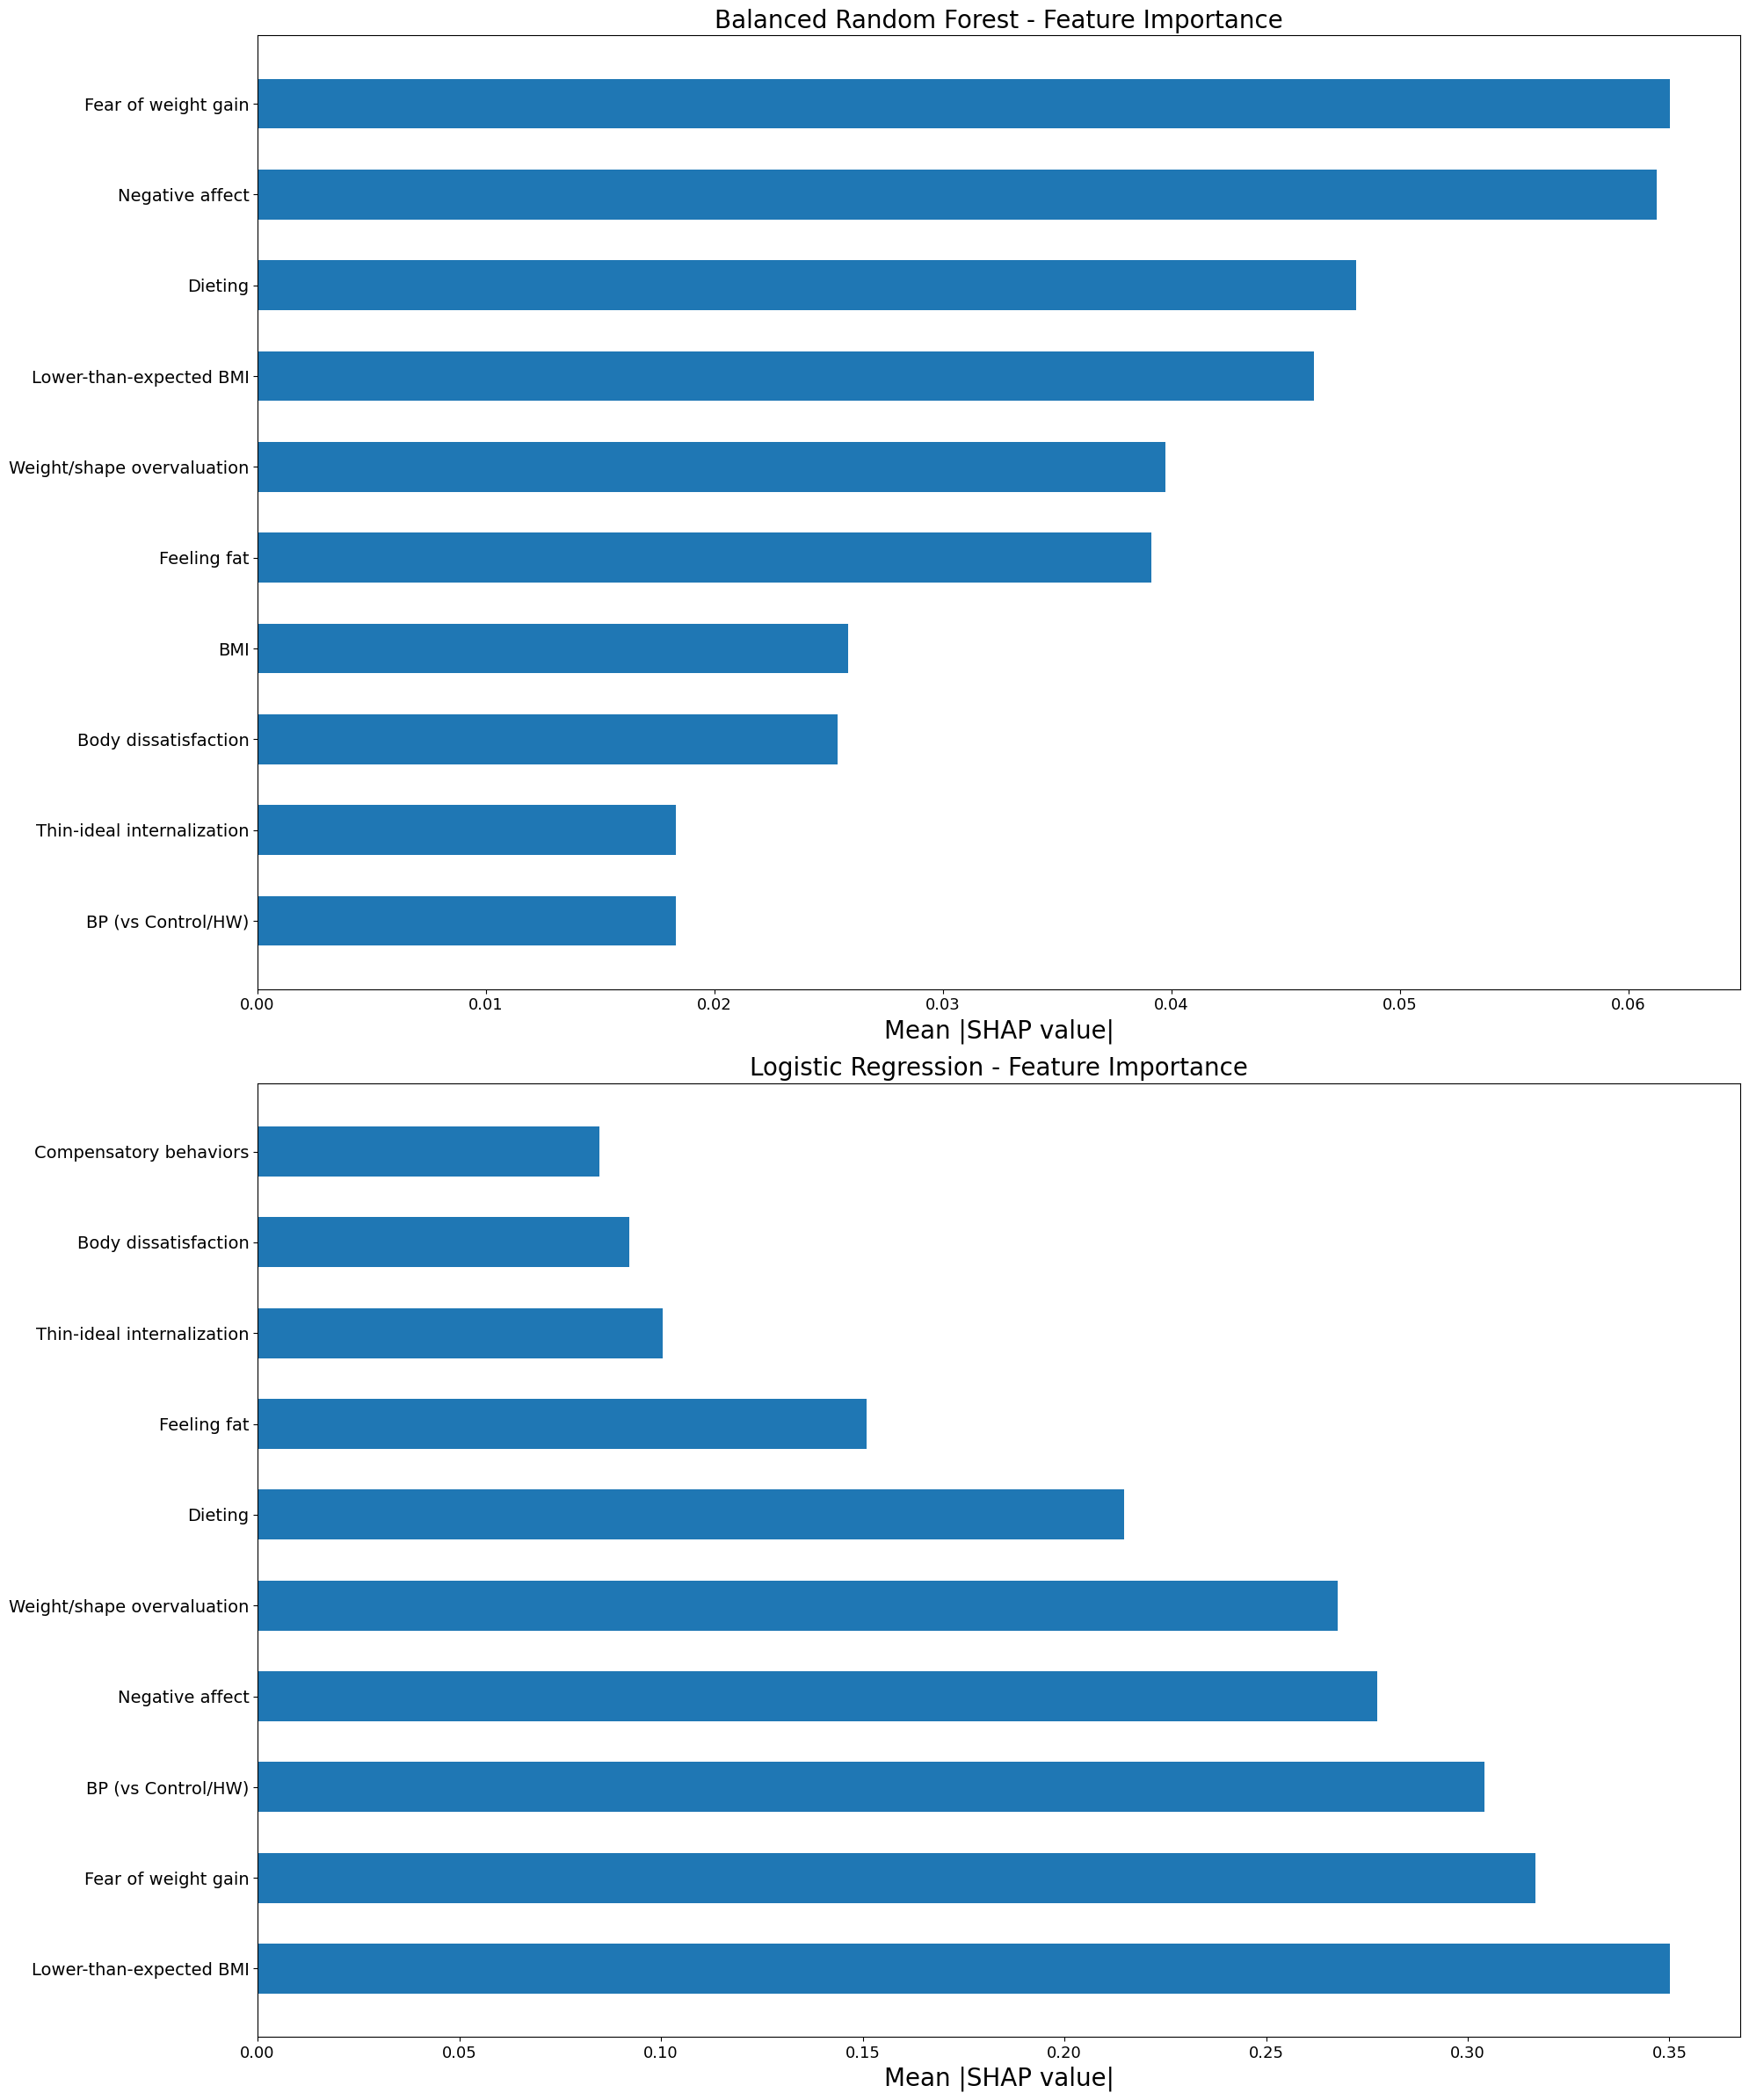

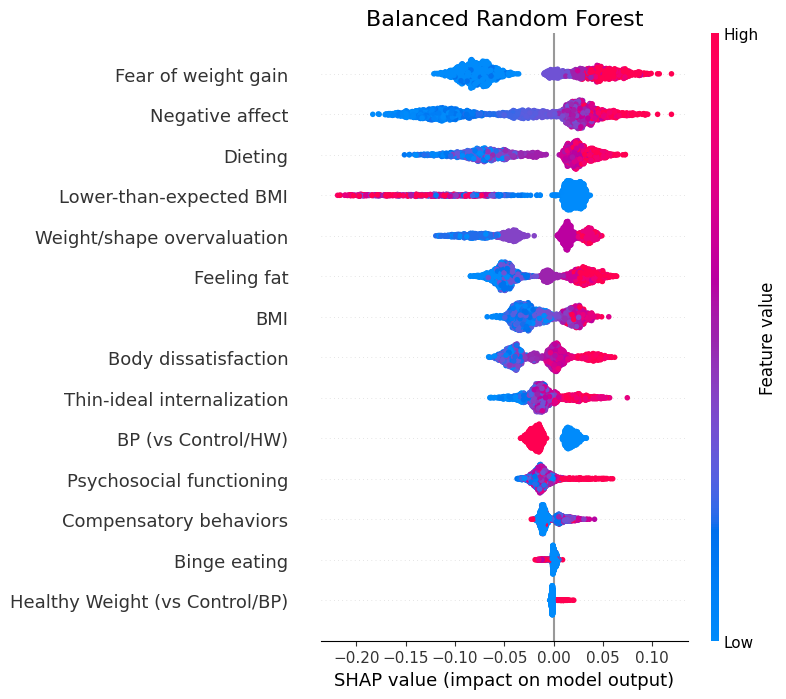

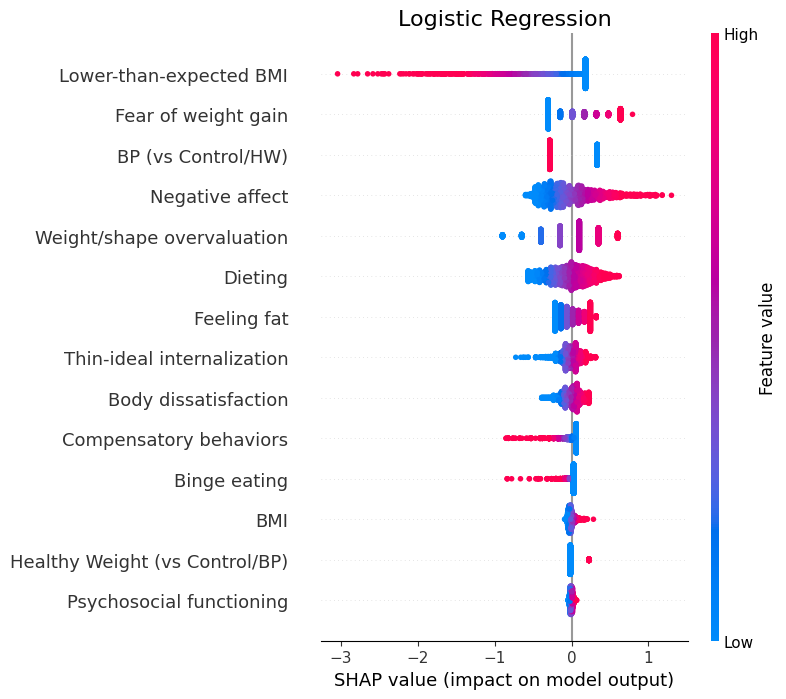

In [ ]:

# Refit on full data
brf_best_est = brf_search.best_estimator_.fit(X, y)
log_best_est = log_search.best_estimator_.fit(X, y)

# Transform X through preprocessors
brf_pre = brf_best_est[:-1]
brf_model = brf_best_est.named_steps["model"]
X_brf_t = pd.DataFrame(brf_pre.transform(X), columns=X.columns, index=X.index)

log_pre = log_best_est[:-1]
log_model = log_best_est.named_steps["model"]
X_log_t = pd.DataFrame(log_pre.transform(X), columns=X.columns, index=X.index)

# Use English feature names for ALL plots
def _plot_label(feature: str) -> str:
    # Remove the generic prefix from condition dummy labels (plots only).
    # Keeps the model/features unchanged; this is display-only.
    label = english_name(feature)
    label = label.replace("Intervention condition:", "").strip()
    return label

english_cols_plot = [_plot_label(c) for c in X.columns]
X_brf_t_named = X_brf_t.copy()
X_brf_t_named.columns = english_cols_plot
X_log_t_named = X_log_t.copy()
X_log_t_named.columns = english_cols_plot

# SHAP explainers
brf_explainer = shap.TreeExplainer(brf_model)
brf_shap_full = brf_explainer(X_brf_t_named)

log_explainer = shap.LinearExplainer(log_model, X_log_t_named)
log_shap = log_explainer(X_log_t_named)

brf_shap = shap.Explanation(
    values=brf_shap_full.values[..., 1] if brf_shap_full.values.ndim == 3 else brf_shap_full.values,
    base_values=brf_shap_full.base_values[..., 1] if np.ndim(brf_shap_full.base_values) == 2 else brf_shap_full.base_values,
    data=brf_shap_full.data,
    feature_names=english_cols_plot,
 )

# Mean |SHAP|
def _mean_abs_importance(expl):
    vals = getattr(expl, "values", expl)
    arr = np.asarray(vals)
    if arr.ndim == 3 and arr.shape[-1] >= 2:
        arr = arr[:, :, 1]
    return np.abs(arr).mean(axis=0)

brf_importance = _mean_abs_importance(brf_shap)
log_importance = _mean_abs_importance(log_shap)

# Bar plots (top 10) — wider and stacked vertically
BAR_TITLE_FONTSIZE = 20
BAR_LABEL_FONTSIZE = 20
BAR_TICK_FONTSIZE_Y = 14
BAR_TICK_FONTSIZE_X = 13

fig, axes = plt.subplots(2, 1, figsize=(20, 24))

brf_imp_df = (
    pd.DataFrame({"feature": english_cols_plot, "importance": brf_importance})
    .sort_values("importance", ascending=False)
    .head(10)
    .sort_values("importance", ascending=False)
 )
axes[0].barh(brf_imp_df["feature"], brf_imp_df["importance"], height=0.55)
axes[0].set_xlabel("Mean |SHAP value|", fontsize=BAR_LABEL_FONTSIZE)
axes[0].set_title("Balanced Random Forest - Feature Importance", fontsize=BAR_TITLE_FONTSIZE)
axes[0].tick_params(axis="y", labelsize=BAR_TICK_FONTSIZE_Y)
axes[0].tick_params(axis="x", labelsize=BAR_TICK_FONTSIZE_X)
axes[0].invert_yaxis()

log_imp_df = (
    pd.DataFrame({"feature": english_cols_plot, "importance": log_importance})
    .sort_values("importance", ascending=False)
    .head(10)
    .sort_values("importance", ascending=True)
 )
axes[1].barh(log_imp_df["feature"], log_imp_df["importance"], height=0.55)
axes[1].set_xlabel("Mean |SHAP value|", fontsize=BAR_LABEL_FONTSIZE)
axes[1].set_title("Logistic Regression - Feature Importance", fontsize=BAR_TITLE_FONTSIZE)
axes[1].tick_params(axis="y", labelsize=BAR_TICK_FONTSIZE_Y)
axes[1].tick_params(axis="x", labelsize=BAR_TICK_FONTSIZE_X)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Beeswarm plots (top 20) — wider
plt.figure(figsize=(20, 7))
shap.plots.beeswarm(brf_shap, max_display=20, show=False)
plt.title("Balanced Random Forest", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 7))
shap.plots.beeswarm(log_shap, max_display=20, show=False)
plt.title("Logistic Regression", fontsize=16)
plt.tight_layout()
plt.show()



## Threshold selection (balanced accuracy)

Find thresholds that maximize balanced accuracy while keeping sensitivity and overall accuracy above 0.6.


In [ ]:
thresholds = np.linspace(0.05, 0.95, 19)


def evaluate_thresholds(name: str, estimator):
    # Out-of-fold probs once; then score all thresholds off the same probs
    probs = cross_val_predict(estimator, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    auc = float(roc_auc_score(y, probs))
    rows = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        bal_acc = (sens + spec) / 2 if np.isfinite(sens) and np.isfinite(spec) else np.nan
        rows.append(
            {
                "threshold": float(thr),
                "auc": auc,
                "accuracy": float(acc) if np.isfinite(acc) else np.nan,
                "sensitivity": float(sens) if np.isfinite(sens) else np.nan,
                "specificity": float(spec) if np.isfinite(spec) else np.nan,
                "balanced_accuracy": float(bal_acc) if np.isfinite(bal_acc) else np.nan,
            }
        )
    results = pd.DataFrame(rows)
    if results["balanced_accuracy"].notna().sum() == 0:
        print(f"{name}: no valid balanced accuracy values")
        return None, results

    best = results.sort_values(["balanced_accuracy", "sensitivity", "specificity"], ascending=[False, False, False]).iloc[0]
    print(
        f"{name}: AUC={best.auc:.3f}  best BalAcc={best.balanced_accuracy:.3f} at thr={best.threshold:.2f} "
        f"(Acc {best.accuracy:.3f}, Sens {best.sensitivity:.3f}, Spec {best.specificity:.3f})"
    )
    display(results.sort_values("balanced_accuracy", ascending=False).head(10))
    return best, results

brf_best_threshold, _brf_tbl = evaluate_thresholds("Balanced RF", brf_best_est)
log_best_threshold, _log_tbl = evaluate_thresholds("Logistic", log_best_est)

candidates = []
if brf_best_threshold is not None:
    candidates.append(("Balanced RF", brf_best_threshold))
if log_best_threshold is not None:
    candidates.append(("Logistic", log_best_threshold))

if candidates:
    winner = sorted(candidates, key=lambda t: t[1]["balanced_accuracy"], reverse=True)[0]
    w = winner[1]
    print(
        f"Selected model: {winner[0]} | "
        f"AUC={w['auc']:.3f}  Acc={w['accuracy']:.3f}  Sens={w['sensitivity']:.3f}  "
        f"Spec={w['specificity']:.3f}  BalAcc={w['balanced_accuracy']:.3f}  @ thr={w['threshold']:.2f}"
    )
else:
    print("No model produced valid balanced accuracy values across thresholds.")


Balanced RF: AUC=0.779  best BalAcc=0.750 at thr=0.40 (Acc 0.659, Sens 0.847, Spec 0.652)


,threshold,auc,accuracy,sensitivity,specificity,balanced_accuracy
7,0.40,0.779466,0.658511,0.847458,0.652389,0.749923
6,0.35,0.779466,0.598404,0.898305,0.588688,0.743496
5,0.30,0.779466,0.523404,0.915254,0.510708,0.712981
8,0.45,0.779466,0.714362,0.677966,0.715541,0.696754
4,0.25,0.779466,0.447872,0.932203,0.432180,0.682192
9,0.50,0.779466,0.765426,0.593220,0.771005,0.682113
3,0.20,0.779466,0.374468,0.949153,0.355848,0.652500
10,0.55,0.779466,0.801596,0.474576,0.812191,0.643384
11,0.60,0.779466,0.847340,0.406780,0.861614,0.634197
2,0.15,0.779466,0.278191,0.983051,0.255354,0.619203


Logistic: AUC=0.789  best BalAcc=0.722 at thr=0.45 (Acc 0.683, Sens 0.763, Spec 0.680)


,threshold,auc,accuracy,sensitivity,specificity,balanced_accuracy
8,0.45,0.788559,0.682979,0.762712,0.680395,0.721554
7,0.40,0.788559,0.629787,0.813559,0.623833,0.718696
9,0.50,0.788559,0.736702,0.677966,0.738605,0.708286
5,0.30,0.788559,0.507447,0.915254,0.494234,0.704744
6,0.35,0.788559,0.567553,0.847458,0.558484,0.702971
11,0.60,0.788559,0.816489,0.576271,0.824272,0.700272
10,0.55,0.788559,0.780319,0.610169,0.785832,0.698001
12,0.65,0.788559,0.851064,0.474576,0.863262,0.668919
4,0.25,0.788559,0.417553,0.932203,0.400879,0.666541
3,0.20,0.788559,0.334574,0.983051,0.313564,0.648307


Selected model: Balanced RF | AUC=0.779  Acc=0.659  Sens=0.847  Spec=0.652  BalAcc=0.750  @ thr=0.40
